In [2]:
import sklearn
import pandas as pd
import numpy as np

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.model_selection import GridSearchCV, cross_val_score

In [16]:
from plotnine import ggplot, aes, geom_point, geom_line, geom_histogram, geom_bar, labs

In [17]:
housing = pd.read_csv('AmesHousing.csv')
housing.head(3)

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000


In [18]:
good_cols = housing.isna().sum() < 100
df = housing.loc[:,good_cols]
df = df.dropna()
df.head(3)

,Order,PID,MS SubClass,MS Zoning,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,...,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,31770,Pave,IR1,Lvl,AllPub,Corner,...,0,0,0,0,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,11622,Pave,Reg,Lvl,AllPub,Inside,...,0,0,120,0,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,14267,Pave,IR1,Lvl,AllPub,Corner,...,0,0,0,0,12500,6,2010,WD,Normal,172000


# Part 1

In [58]:
X = df.drop(["SalePrice", "Order", "PID"], axis = 1)
y = df["SalePrice"]

ct = ColumnTransformer(
    [("dummify", OneHotEncoder(sparse_output = False, handle_unknown = 'ignore'),
      make_column_selector(dtype_include = object)),
     ("standardize", StandardScaler(), 
      make_column_selector(dtype_include = np.number))],
    remainder = "passthrough"
).set_output(transform = "pandas")

ridge_pipeline = Pipeline(
    [("preprocessing", ct),
     ("ridge_regression", Ridge(alpha = 1.0))]
)

cross_val_score(ridge_pipeline, X, y, cv = 5, scoring = 'r2')

array([0.89815807, 0.91744024, 0.79493606, 0.78522563, 0.91389818])

In [36]:
linear_pipeline = Pipeline(
    [("preprocessing", ct),
     ("linear_regression", LinearRegression())]
)

cross_val_score(linear_pipeline, X, y, cv = 5, scoring = 'r2')

array([-6.50101507e+18, -5.74294993e+19, -1.79147612e+17, -2.63367991e+19,
       -3.81043956e+18])

Cross Validation Scores are much stronger with the Ridge Regression Model

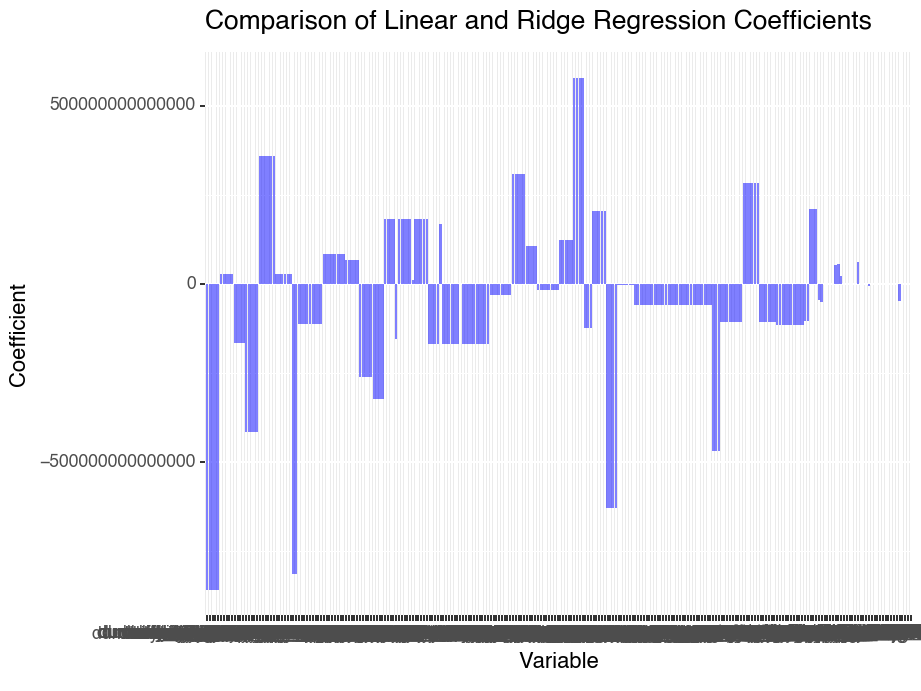

<Figure Size: (460 x 345)>

In [52]:
linear_fitted = linear_pipeline.fit(X, y)
linear_coef = linear_fitted.named_steps['linear_regression'].coef_

ridge_fitted = ridge_pipeline.fit(X, y)
ridge_coef = ridge_fitted.named_steps['ridge_regression'].coef_

coef_df = pd.DataFrame({'Variable': ct.fit_transform(X).columns,
                        'Linear': linear_coef, 'Ridge': ridge_coef})

(ggplot(coef_df) + aes(x = 'Variable') +
    geom_bar(aes(y = 'Linear'), stat = 'identity', fill = 'blue', alpha = 0.5) +
    geom_bar(aes(y = 'Ridge'), stat = 'identity', fill = 'red', alpha = 0.5) +
    labs(title="Comparison of Linear and Ridge Regression Coefficients",
         x = "Variable",
         y = "Coefficient")
)

# Part 2

In [25]:
lambdas = [0.001, 0.01, 0.1, 1, 10]

for item in lambdas:
    ridge_pipeline = Pipeline(
        [("preprocessing", ct),
         ("ridge", Ridge(alpha = item))]
    )
    score = cross_val_score(ridge_pipeline, X, y, cv = 5, scoring = 'r2')
    print(score, score.mean())

[0.8972854  0.91040618 0.78901601 0.7721318  0.90076168] 0.8539202138390545
[0.89734306 0.91061417 0.7891259  0.77253192 0.90131686] 0.8541863831018921
[0.89774358 0.91230557 0.79010977 0.77576412 0.90558729] 0.8563020644831025
[0.89815807 0.91744024 0.79493606 0.78522563 0.91389818] 0.8619316345217337
[0.8977621  0.92081211 0.80057243 0.78711955 0.91509487] 0.8642722110166746


The largest Lambda (10) had the highest average Cross Validation Score

# Part 3

In [53]:
lambdas = [0.001, 0.01, 0.1, 1, 10]

for item in lambdas:
    lasso_pipeline = Pipeline(
        [("preprocessing", ct),
         ("lasso", Lasso(alpha = item))]
    )
    score = cross_val_score(ridge_pipeline, X, y, cv = 5, scoring = 'r2')
    print(score, score.mean())

[0.89815807 0.91744024 0.79493606 0.78522563 0.91389818] 0.8619316345217337
[0.89815807 0.91744024 0.79493606 0.78522563 0.91389818] 0.8619316345217337
[0.89815807 0.91744024 0.79493606 0.78522563 0.91389818] 0.8619316345217337
[0.89815807 0.91744024 0.79493606 0.78522563 0.91389818] 0.8619316345217337
[0.89815807 0.91744024 0.79493606 0.78522563 0.91389818] 0.8619316345217337


# Part 4

In [68]:
lambdas = [0.02, 0.03, 0.04]
alphas = [0.50, 0.60, 0.70]

for item1 in lambdas:
    for item2 in alphas:
        elastic_pipeline = Pipeline(
        [("preprocessing", ct),
         ("elastic", ElasticNet(alpha = item1, l1_ratio = item2))]
        )
        score = cross_val_score(elastic_pipeline, X, y, cv = 5, scoring = 'r2')
        print(score, score.mean())

[0.89603977 0.92223797 0.80004082 0.78404947 0.91606506] 0.8636866185714853
[0.89668091 0.92186739 0.80042748 0.78514174 0.91585235] 0.8639939738374898
[0.89730965 0.92135293 0.80064893 0.78626385 0.91549797] 0.8642146657016416
[0.89449349 0.9227565  0.79885323 0.78155581 0.91619053] 0.8627699124695916
[0.89540723 0.92250285 0.79958285 0.78300887 0.91617236] 0.8633348348560878
[0.89635988 0.92206812 0.80024774 0.78458969 0.9159748 ] 0.8638480471429126
[0.89308108 0.92292541 0.79766207 0.77940396 0.91598008] 0.8618105193156194
[0.8941995  0.92281173 0.79860897 0.78109919 0.91616864] 0.8625776049961484
[0.89540697 0.92250297 0.79958285 0.78300861 0.91617295] 0.8633348699406163
